# Generator, target_func, preprocessing

In [106]:
import numpy as np
import networkx as nx

#simple DAG generator
def dag_generator(n_node: int = 10, 
                  n_edge: int = 10, 
                  low_res: int = 1,
                  high_res: int = 8,
                  random_state: int = 42):
    """    
    Parameters
    ----------
    n_node: int
        Number of nodes in Directed Acyclic Graph.
        
    n_edge: int
        Number of edges in Directed Acyclic Graph.
        
    low_res: int
        The low bound of the resource of task result.
        
    high_res: int
        The high bound of the resource of task result.
        
    random_state: int
        The random state for np.seed.
    ----------
    
    Returns
    -------
    (dag, resource_matrix) where
        1) dag is the nx.Graph that represent Directed Acyclic Graph;
        2) resource_matrix is a matrix of task dependencies. The matrix 
           cell (i, j) contains a non-zero value if task j depends on the 
           result of task i. This value is equal to the amount of resources 
           that the result of task i takes up.
    -------
    """
    
    def make_edge(nodes, dag):
        stop = False
        while not stop:
            edge = np.random.choice(nodes, size=2)
            if edge[0] < edge[1] and edge not in dag.edges:
                stop = True
        return edge
    
    np.random.seed(random_state)
    res_depend = np.zeros((n_node, n_node))
    dag = nx.Graph()
    nodes = np.arange(n_node)
    node_res = np.random.randint(low_res, high_res, size=n_node)
    dag.add_nodes_from(nodes)
    for _ in range(n_edge):
        edge = make_edge(nodes, dag)        
        dag.add_edge(*edge)
        res_depend[edge[0], edge[1]] = node_res[edge[0]]
    for node_id in nodes:
        res_depend[node_id, node_id] = node_res[node_id] #save the amount of resource of task node_id
    return dag, res_depend

In [110]:
def target_function(tasks, wait_list: set):
    return sum(map(lambda task_id: tasks[task_id].result_volume, wait_list))

In [111]:
import numpy as np

def data_preprocessing(resource_matrix: (np.ndarray)):
    """
    Make Task instances from resource_matrix. This instances contains
    predecessors and sucessors sets, the amount of resources needed for 
    the task result and task identifier.
    
    Parameters
    ----------
    resource_matrix: np.ndarray
        Matrix of task dependencies. The matrix cell (i, j) contains a non-zero 
        value if task j depends on the result of task i. This value is equal to 
        the amount of resources that the result of task i takes up.
    ----------
    
    Returns
    -------
    TaskDct object that contains task instances.
    -------
    """
    tasks_count = resource_matrix.shape[0]
    tasks = TaskDct()
    for task_id in range(resource_matrix.shape[0]):
        row = np.arange(task_id + 1, tasks_count)
        numerable_row = np.vstack((resource_matrix[task_id, row], row))
        successors = numerable_row[1, numerable_row[0] > 0].astype('int32')
        col = np.arange(0, task_id)
        numerable_col = np.vstack((resource_matrix[col, task_id], col))
        predecessors = numerable_col[1, numerable_col[0] > 0].astype('int32')
        tasks[task_id] = Task(task_id, resource_matrix[task_id, task_id], predecessors, successors)
    return tasks

# Environment components

## Task class

In [107]:
from copy import deepcopy

#simple task
class Task:
    def __init__(self, 
                 task_id: int, 
                 result_volume: int,
                 predecessors, 
                 successors):
        self.task_id = task_id
        self.result_volume = result_volume
        self.predecessors = set(predecessors)
        self.successors = set(successors)
        
    def __str__(self):
        return "{" \
               f"\n\ttask_id: {self.task_id}" \
               f"\n\tresult_volume: {self.result_volume}" \
               f"\n\tpredecessors: {self.predecessors}" \
               f"\n\tsuccessors: {self.successors}" \
               "\n}"
        
    def __repr__(self):
        return self.__str__()
        
    def drop_child(self, child_id: int):
        self.successors.remove(child_id)
        
    def drop_parent(self, parent_id: int):
        self.predecessors.remove(parent_id)
        
    def copy(self):
        return deepcopy(self)

## TaskDct class

In [108]:
from copy import deepcopy

#simple task dictionary
class TaskDct(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__type_checker()
        
    def __setitem__(self, key: int, val: Task):
        self.__type_checker(key, val)
        super().__setitem__(key, val)
        
    def __str__(self):
        return ',\n'.join([f"{key}: {val}" for key, val in self.items()])
        
    def __type_checker(self, key=None, val=None):
        if key is None:
            if not all(map(lambda key: isinstance(key, int), self.keys())):
                raise TypeError("Keys must be int")
        else:
            if not isinstance(key, int):
                raise TypeError("Keys must be int")
        if val is None:
            if not all(map(lambda val: isinstance(val, Task), self.values())):
                raise TypeError("Values must be Task")
        else:
            if not isinstance(val, Task):
                raise TypeError("Keys must be int")        
                
    def copy(self):
        return TaskDct({key: val.copy() for key, val in self.items()})

## Solution class

In [109]:
#simple solution
class Solution(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__type_checker()
        self.solution_cost = 0
        
    def __type_checker(self, val=None):
        if val is None:
            if not all(map(lambda val: isinstance(val, Task), self)):
                raise TypeError("Values must be Task")
        else:
            if not isinstance(val, Task):
                raise TypeError("Values must be Task")
                
    def append(self, val):
        self.__type_checker(val)
        super().append(val)
        
    def __setitem__(self, val):
        self.__type_checker(val)
        super().__setitem__(val)
        
    def __add__(self, lst):
        if not isinstance(lst, Solution):
            raise TypeError(f'Can only concatenate Solution (not "{type(lst)}") to Solution')
        return super().__add__(lst)    

# Optimization algorithms

## BaseOptimization

In [112]:
class BaseOptimization:
    """
    Base class for all scheduling algorithms
    """
    def __init__(self, solution_cost):
        """
        Parameters
        ----------            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
        ----------
        """        
        if callable(solution_cost):
            self.__cost = solution_cost
        else:
            raise ValueError(f"solution_cost must be callable object not a {type(solution_cost)}")
            
    def __setattr__(self, name, value): 
        if name == 'cost':            
            raise AttributeError("'BaseOptimization' object attribute 'cost' is read-only" + 
                                 " and can only be defined using the '__init__' method") 
        else:
            super().__setattr__(name, value)
          
    def make_state(self, tasks: TaskDct):
        """
        Make initial state of environment by creating several task sets such
        as acceptable tasks that can be scheduled at the initial time, waiting 
        tasks that have already been completed but their successors have not yet
        been completed.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        (acceptable, waiting, solution) where
            1) acceptable is a set of tasks that can be scheduled for the 
               current iteration;
            2) waiting is a set of complete tasks indexes whose successors 
               have not yet been completed;
            3) solution is a Solution instance that represent schedule.
        -------
        """
        waiting = set()
        acceptable = {task.task_id 
                      for task in tasks.values() 
                      if len(task.predecessors) == 0}
        solution = Solution()
        return acceptable, waiting, solution
    
    def update_state(self,
                     tasks: TaskDct, 
                     task_id: int, 
                     acceptable: set, 
                     waiting: set, 
                     solution: Solution):
        """
        Update task sets. After completing regular task, ther could appear
        new tasks that acceptable for schedule.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        task_id: int
            task id of the task which we decided to append to the solution.
        
        acceptable: set 
        A set of tasks that can be scheduled for the current iteration.
        
        waiting: set
        A set of complete tasks indexes whose successors have not yet 
        been completed.
        
        solution: Solution
        A Solution instance that represent schedule.
        ----------
        
        Returns
        -------
        None
        -------
        """
        solution.append(tasks[task_id].copy())
        if len(tasks[task_id].successors) > 0:
            waiting.add(task_id)
        wait_drop = set()
        for tid in waiting:
            if task_id in tasks[tid].successors:
                tasks[tid].drop_child(task_id)
                if len(tasks[tid].successors) == 0:
                    wait_drop.add(tid)
        waiting.difference_update(wait_drop)
        acceptable.remove(task_id)
        unscheduled = {i for i in range(len(tasks))}.difference([task.task_id for task in solution]).difference(acceptable)
        for tid in unscheduled:
            if len(tasks[tid].predecessors.intersection(waiting)) == len(tasks[tid].predecessors):
                acceptable.add(tid)        
        
    def cost(self, *args, **kwargs):
        """
        Calculate the solution cost by solution_cost function.
        
        Returns
        -------
        The value of the decision function for specified solution.
        -------
        """   
        return self.__cost(*args, **kwargs)
        
    def schedule(self, *args, **kwargs):
        pass

## GreedyOptimization

In [113]:
class GreedyOptimization(BaseOptimization):
    """The class represent a Greedy oprimization algorithm"""
    def __init__(self, solution_cost):
        """
        Parameters
        ----------            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
        ----------
        """
        super().__init__(solution_cost)
        
    def heuristic_info(self, tasks: TaskDct, acceptable: set, waiting: set):
        """
        Calculate heuristic information based on current load of the environment.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        acceptable:
            A set of task indexes that can be scheduled for the 
            current iteration.
            
        waiting:
            A set of completed task indexes whose successors have 
            not yet been completed.
        ----------
        
        Returns
        -------
        Dictionary of (task_id, heuristic_info) pairs where the 
        first element is the key and the second is the value.
        -------
        """
        visions = dict()
        for task_id in acceptable:
            resource_free = (sum([tasks[pred_id].result_volume 
                                 for pred_id in tasks[task_id].predecessors 
                                 if tasks[pred_id].successors == {task_id}])
                             - tasks[task_id].result_volume)
            resource_busy = sum([tasks[wait_id].result_volume for wait_id in waiting])
            visions[task_id] = 1. / (resource_busy - resource_free)
        return visions
    
    def choice(self, visions):
        """
        Select a task that will be scheduled next.
        
        Parameters
        ----------
        visions: dict
            Dictionary of (task_id, heuristic_info) pairs where the 
            first element is the key and the second is the value.
        ----------
        
        Returns 
        -------
        The task_id of the task for which the heuristic information was greater.
        -------
        """
        item = None
        for itm in visions.items():
            if item is None or itm[1] > item[1]:
                item = itm
        return item[0]
        
    def schedule(self, tasks: TaskDct):
        """
        Make schedule using greedy optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_cp = tasks.copy()
        acceptable, waiting, solution = self.make_state(tasks_cp)
        for iter_num in range(len(tasks_cp)):
            visions = self.heuristic_info(tasks_cp, acceptable, waiting)
            task_id = self.choice(visions)
            self.update_state(tasks_cp, task_id, acceptable, waiting, solution)
            current_cost = self.cost(tasks_cp, waiting)
            if current_cost > solution.solution_cost:
                solution.solution_cost = current_cost
        return solution

## AntColonyOptimization

In [141]:
import numpy as np

class AntColonyOptimization(BaseOptimization):
    """
    This class represent Ant Colony Optimization algorithm.
    """
    def __init__(self, 
                 pheromone_decay: float, 
                 threshold: float, 
                 pheromone_influence: float,
                 heuristic_influence: float,
                 iters_count: int, 
                 baseline_opt: BaseOptimization,
                 solution_cost):
        """
        Parameters
        ----------
        pheromone_decay: float
            pheromone_decay is pherome decay coefficient.
            This parameter represent 'ro' parameter in the algorithm description.
            It is used by local/global pheromone trail updater.
            
        threshold: float
            This parameter represent q0 parameter in the algorithm description.
            It is used by the selection formula for scheduling tasks.                    
            
        pheromone_influence: float
            The influnce of the pheromone trail on the choice of the next 
            scheduled task.
        
        heuristic_influence: float
            The influnce of the heuristic information on the choice of the next 
            scheduled task.
            
        iters_count: int
            Ther iterations count (ants count from algorithm description) of 
            algorithm.
        
        baseline_opt: BaseOptimization
            Baseline algorithm for generating a basic solution.
            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
        ----------
        """
        self.phe_decay = pheromone_decay
        self.threshold = threshold
        self.iters_count = iters_count
        self.phe_influence = pheromone_influence
        self.heu_influence = heuristic_influence
        self.baseline_opt = baseline_opt
        super().__init__(solution_cost)
    
    def heuristic_info(self, tasks: TaskDct, acceptable: set, waiting: set):
        """
        Calculate heuristic information based on current load of the environment.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        acceptable:
            A set of task indexes that can be scheduled for the 
            current iteration.
            
        waiting:
            A set of completed task indexes whose successors have 
            not yet been completed.
        ----------
        
        Returns
        -------
        Dictionary of (task_id, heuristic_info) pairs where the 
        first element is the key and the second is the value.
        -------
        """
        visions = dict()
        for task_id in acceptable:
            resource_free = (sum([tasks[pred_id].result_volume 
                                 for pred_id in tasks[task_id].predecessors 
                                 if tasks[pred_id].successors == {task_id}])
                             - tasks[task_id].result_volume)
            resource_busy = sum([tasks[wait_id].result_volume for wait_id in waiting])
            visions[task_id] = 1. / (resource_busy - resource_free)
        return visions
    
    def choice(self, visions, pheromone_row):
        """
        Select a task that will be scheduled next.
        
        Parameters
        ----------
        visions: dict
            Dictionary of (task_id, heuristic_info) pairs where the 
            first element is the key and the second is the value.
        ----------
        
        Returns 
        -------
        The task_id of the task for which the heuristic information was greater.
        -------
        """
        q = np.random.uniform(0, 1)
        task_ids = list(visions.keys())
        phe = np.power(pheromone_row[task_ids], self.phe_influence)
        heu = np.power(np.array(list(visions.values())), self.heu_influence)
        prod = phe * heu
        if q <= self.threshold:
            argmax = np.argmax(prod)
            task_id = task_ids[argmax]
        else:
            probs = prod / prod.sum()
            task_id = np.random.choice(task_ids, size=1, p=probs)[0]
        return task_id    
    
    def local_pheromone_update(self, 
                               phe_matr: np.ndarray, 
                               task_id: int, 
                               pos: int,
                               init_trail: float):
        """
        Update pheromone value for cell (pos, task_id).
        
        Parameters
        ----------
        phe_matr: np.ndarray
            A pheromone trail matrix where columns represent tasks and
            rows represent positions in the schedule.
            
        task_id: int
            The number of the task that was added to the local schedule.
            
        pos: int
            The position on that the task was added.
            
        init_trail: float
            The initial pheromone trail value that was obtained from the
            baseline solution cost.
        ----------
        
        Returns 
        -------
        None
        -------
        """
        phe_matr[pos, task_id] = ((1 - self.phe_decay) * phe_matr[pos, task_id] 
                                  + self.phe_decay * init_trail)
        
    def global_pheromone_update(self, 
                                phe_matr: np.ndarray, 
                                solution: Solution = None):
        """
        Update pheromone matrix.
        
        Parameters
        ----------
        phe_matr: np.ndarray
            A pheromone trail matrix where columns represent tasks and
            rows represent positions in the schedule.
            
        solution: Solution
            Current local schedule.
        ----------
        
        Returns 
        -------
        None
        -------
        """
        phe_matr += (1 - self.phe_decay) * phe_matr
        if solution is not None:
            # detected best solution => update best (pos, task_id) cells
            rows = np.arange(len(solution))
            cols = np.array([task.task_id for task in solution])
            phe_matr[rows, cols] += self.phe_decay / solution.solution_cost
    
    def schedule(self, tasks: TaskDct):
        """
        Make schedule by using Ant Colony Optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_count = len(tasks)
        best_solution = self.baseline_opt.schedule(tasks)
        init_trail = 1 / best_solution.solution_cost
        pheromone_matrix = np.ones((tasks_count, tasks_count)) * init_trail
        for iter_num in range(self.iters_count):
            tasks_cp = tasks.copy()
            acceptable, waiting, solution = self.make_state(tasks_cp)
            for pos in range(tasks_count):
                visions = self.heuristic_info(tasks_cp, acceptable, waiting)
                task_id = self.choice(visions, pheromone_matrix[pos, :])
                self.update_state(tasks_cp, task_id, acceptable, waiting, solution)
                current_cost = self.cost(tasks_cp, waiting)
                if current_cost > solution.solution_cost:
                    solution.solution_cost = current_cost
                self.local_pheromone_update(pheromone_matrix, task_id, pos, init_trail)
            if solution.solution_cost < best_solution.solution_cost:
                best_solution = solution
                self.global_pheromone_update(pheromone_matrix, best_solution)
            else:
                # solution is not the best => usual pheromone trail update
                self.global_pheromone_update(pheromone_matrix)
        return best_solution

# Experiments

## GridSearch

In [148]:
from copy import deepcopy
from itertools import product

class GridSearch:
    def __init__(self, optimizer_cls: BaseOptimization, params_grid: dict):
        """
        GridSearch is used for searching parameters on the grid to find 
        the best combination. It is assumed that the best combination 
        of parameters can give the best optimization algorithm.
        
        Parameters
        ----------
        optimizer_cls: BaseOptimization
            A class representing an optimization algorithm for which we want
            to find the best hyperparameters.
            
        params_grid: dict
            A dictionary that contains key-value pairs where the key is the 
            parameter name and the value is list/tuple/np.1darray of parameter 
            values.                    
        ----------
        """
        self.optimizer_cls = optimizer_cls
        self.params_grid = self.__make_grid(params_grid)
        self.grid_search_results = list()
        self.best_optimizer_ = None
        self.best_optimizer_params_ = None
        
    def __make_grid(self, params_grid: dict):
        return [{key: val for key, val in zip(params_grid.keys(), params)} 
                for params in product(*params_grid.values())]
        
    def fit(self, samples: list):    
        """
        This method searches the params_grid and keeps results.
        
        Parameters
        ----------
        samples: list
            samples is list contains TaskDct instances. Optimizer makes
            schedule for every instances with every combination of parameters.
        ----------
        
        Returns
        -------
        GridSearch instance that keeps grid search results.
        -------
        """
        for params in self.params_grid:
            costs = []
            optimizer = self.optimizer_cls(**params)
            for sample in samples:
                costs.append(optimizer.schedule(sample).solution_cost)
            self.grid_search_results.append({'params': params, 
                                             'costs': costs, 
                                             'mean_cost': np.mean(costs)})
        sorted_results = sorted(self.grid_search_results, key=lambda elem: elem['mean_cost'], reverse=True)
        self.best_optimizer_params_ = sorted_results[0]['params']
        self.best_optimizer_ = self.optimizer_cls(**self.best_optimizer_params_)
        return self

## Selection of ACO hyperparameters

In [149]:
# samples generation
samples = list()
n_nodes_lst = [10, 20, 30]
n_edges_lst = [15, 40, 60]
rand_states = [4, 8, 15, 16, 23, 42]

for n_nodes, n_edges, random_state in zip(n_nodes_lst, n_edges_lst, rand_states):
    sample = data_preprocessing(dag_generator(n_nodes, n_edges, 1, 10, random_state)[1])
    samples.append(sample)

In [155]:
params_grid = {
    'pheromone_decay': np.logspace(-2, 0, 10),
    'threshold': np.logspace(-2, 0, 10),
    'pheromone_influence': np.logspace(-2, 0, 10),
    'heuristic_influence': np.logspace(-2, 0, 10),
    'iters_count': (20, ),
    'baseline_opt': (GreedyOptimization(target_function), ),
    'solution_cost': (target_function, )
}

grid_search = GridSearch(AntColonyOptimization, params_grid)
grid_search.fit(samples)

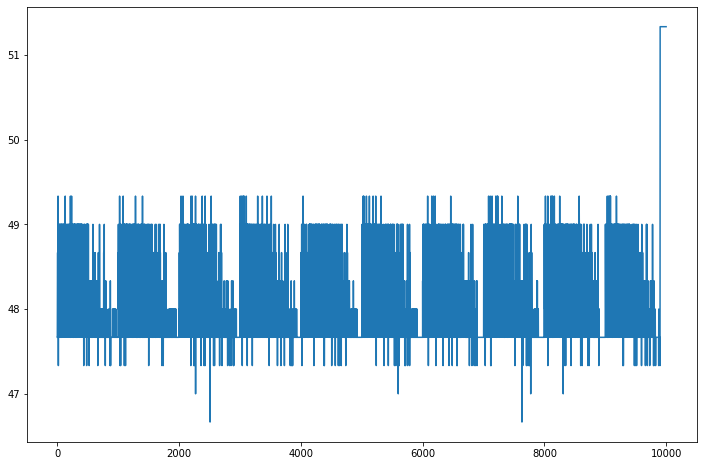

In [157]:
import matplotlib.pyplot as plt

results = grid_search.grid_search_results
plt.figure(figsize=(12, 8))
plt.plot([res['mean_cost'] for res in results])

## Greedy vs ACO

In [158]:
phe_decay = 0.8
threshold = 0.5
phe_influence = 0.6
heu_influence = 0.4
iters_count = 20
baseline_opt = GreedyOptimization(target_function)
solution_cost = target_function

aco_opt = AntColonyOptimization(phe_decay, 
                                threshold, 
                                phe_influence, 
                                heu_influence, 
                                iters_count, 
                                baseline_opt, 
                                solution_cost)

In [167]:
# samples generation
samples = list()
n_nodes_lst = [40, 80, 100, 120, 150]
rand_states = [4, 8, 15, 16, 23, 42]
task_volume = []

for n_nodes in n_nodes_lst:
    n_edges_lst = [int(n_nodes * coef) for coef in (1.25, 1.5, 1.75, 2, 2.25)]
    for n_edges in n_edges_lst:
        task_volume.append((n_nodes, n_edges))
        samples.append([])
        for random_state in rand_states:
            sample = data_preprocessing(dag_generator(n_nodes, n_edges, 1, 10, random_state)[1])
            samples[-1].append(sample)

greedy_costs = []
aco_costs = []
for sample_group in samples:
    greedy_cost = aco_cost = 0
    for sample in sample_group:
        greedy_cost += baseline_opt.schedule(sample).solution_cost
        aco_cost += aco_opt.schedule(sample).solution_cost
    greedy_costs.append(greedy_cost / len(sample_group))
    aco_costs.append(aco_cost / len(sample_group))

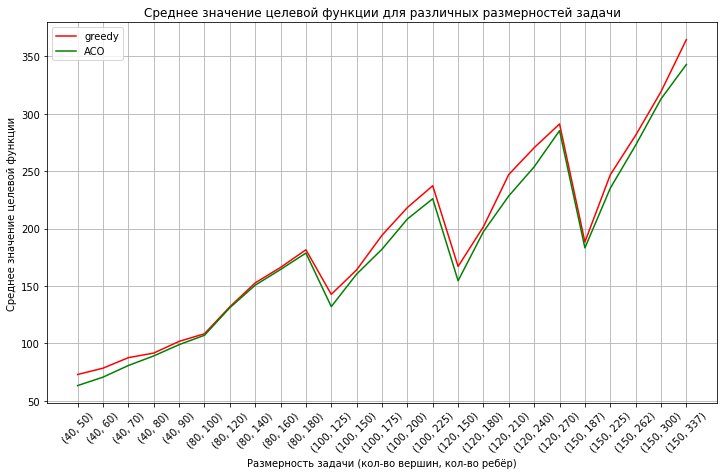

In [168]:
plt.figure(figsize=(12, 7))
plt.title("Среднее значение целевой функции для различных размерностей задачи")
plt.plot([str(vol) for vol in task_volume], greedy_costs, c='red', label='greedy')
plt.plot([str(vol) for vol in task_volume], aco_costs, c='green', label='ACO')
plt.xlabel("Размерность задачи (кол-во вершин, кол-во ребёр)")
plt.ylabel("Среднее значение целевой функции")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()